In [27]:
import os, sys, json
import re
from os import path
import numpy as np
from PIL import Image
from cntk import load_model
from easydict import EasyDict as edict
import IPython.display as D
from sklearn import metrics
import requests
import base64
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import time

from sklearn.metrics import confusion_matrix
python_version = sys.version_info.major

# Intro


## Object Detection 
![](https://i.stack.imgur.com/mFBCV.png)

### Fast RCNN
![](https://i.ytimg.com/vi/xzw3lcdllOU/maxresdefault.jpg)
### Faster RCNN
![](https://jhui.github.io/assets/rcnn/st8.png)

Set up cntk path

In [28]:
cntk_path = "C:\\local\\cntk"
cntk_scripts_path = path.join(cntk_path, r"Examples/Image/Detection/")
sys.path.append(cntk_scripts_path)

from FasterRCNN.FasterRCNN_eval import FasterRCNN_Evaluator
from utils.config_helpers import merge_configs
import utils.od_utils as od

# Helpers

In [29]:
def create_map_file_from_folder(root_folder, class_mapping, include_unknown=False, valid_extensions=['.jpg', '.jpeg', '.png']):
    map_file_name = os.path.join(root_folder, "map.txt")
    
    map_file = None

    if python_version == 3: 
        map_file = open(map_file_name , 'w', encoding='utf-8')
    else:
        map_file = open(map_file_name , 'w')

    for class_id in range(0, len(class_mapping)):
        folder = os.path.join(root_folder, class_mapping[class_id])
        if os.path.exists(folder):
            for entry in os.listdir(folder):
                filename = os.path.abspath(os.path.join(folder, entry))
                if os.path.isfile(filename) and os.path.splitext(filename)[1].lower() in valid_extensions:
                    try:
                        map_file.write("{0}\t{1}\n".format(filename, class_id))
                    except UnicodeEncodeError:
                        continue

    if include_unknown:
        for entry in os.listdir(root_folder):
            filename = os.path.abspath(os.path.join(root_folder, entry))
            if os.path.isfile(filename) and os.path.splitext(filename)[1].lower() in valid_extensions:
                try:
                    map_file.write("{0}\t-1\n".format(filename))
                except UnicodeEncodeError:
                    continue
                    
    map_file.close()  
    
    return map_file_name
  

def create_class_mapping_from_folder(root_folder):
    classes = []
    for _, directories, _ in os.walk(root_folder):
        for directory in directories:
            classes.append(directory)
    return np.asarray(classes)

In [30]:
# http://scikit-learn.org/stable/modules/model_evaluation.html
# PRECISION: What percent of positive predictions were correct? PR=TP/Total Predicted positive
# RECALL: What percent of the positive cases did you catch?? R=TP/Total
# Real Positive


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [31]:
training_folder = 'C:\local\cntk\Examples\Image\DataSets\Beverages\Recognition\Train'
testing_folder = 'C:\local\cntk\Examples\Image\DataSets\Beverages\Recognition\Test'
class_mapping = create_class_mapping_from_folder(training_folder)
training_map = create_map_file_from_folder(testing_folder, class_mapping)
testing_map = create_map_file_from_folder(testing_folder, class_mapping, include_unknown=True)

In [32]:
available_detectors = ['FasterRCNN']
out_dir = r'C:\local\cntk\Examples\Image\DataSets\Beverages\Detection\out'

def get_configuration(classes):
    # load configs for detector, base network and data set
    from FasterRCNN.FasterRCNN_config import cfg as detector_cfg

    # for VGG16 base model use:         from utils.configs.VGG16_config import cfg as network_cfg
    # for AlexNet base model use:       from utils.configs.AlexNet_config import cfg as network_cfg
    from utils.configs.AlexNet_config import cfg as network_cfg
    dataset_cfg = generate_data_cfg(classes)
    return merge_configs([detector_cfg, network_cfg, dataset_cfg, {'DETECTOR': 'FasterRCNN'}])

def generate_data_cfg(classes):
    cfg = edict({"DATA":edict()})
    cfg.NUM_CHANNELS = 3 # image channels
    cfg["DATA"].CLASSES = classes
    cfg["DATA"].NUM_CLASSES = len(classes)
    return cfg

def get_classes_description(model_file_path, classes_count):
    model_dir = path.dirname(model_file_path)
    classes_names = {}
    model_desc_file_path = path.join(model_dir, 'class_map.txt')
    if not path.exists(model_desc_file_path):
        # use default parameter names:
        return [ "class_{}".format(i) for i in range(classes_count)]
    with open(model_desc_file_path) as handle:
        class_map = handle.read().strip().split('\n')
        return [class_name.split('\t')[0] for class_name in class_map]

In [33]:
def detect(img_path, evaluator, cfg):
    # detect objects in single image
    regressed_rois, cls_probs = evaluator.process_image(img_path)
    bboxes, labels, scores = od.filter_results(regressed_rois, cls_probs, cfg)
    # visualize detections on image   
    outpath = path.join(out_dir, path.basename(img_path))
    od.visualize_results(img_path, bboxes, labels, scores, cfg, store_to_path=outpath)
    return bboxes, labels, scores

# Example 

Lets look again at the picture our clasifer struggled with

Invalid Example


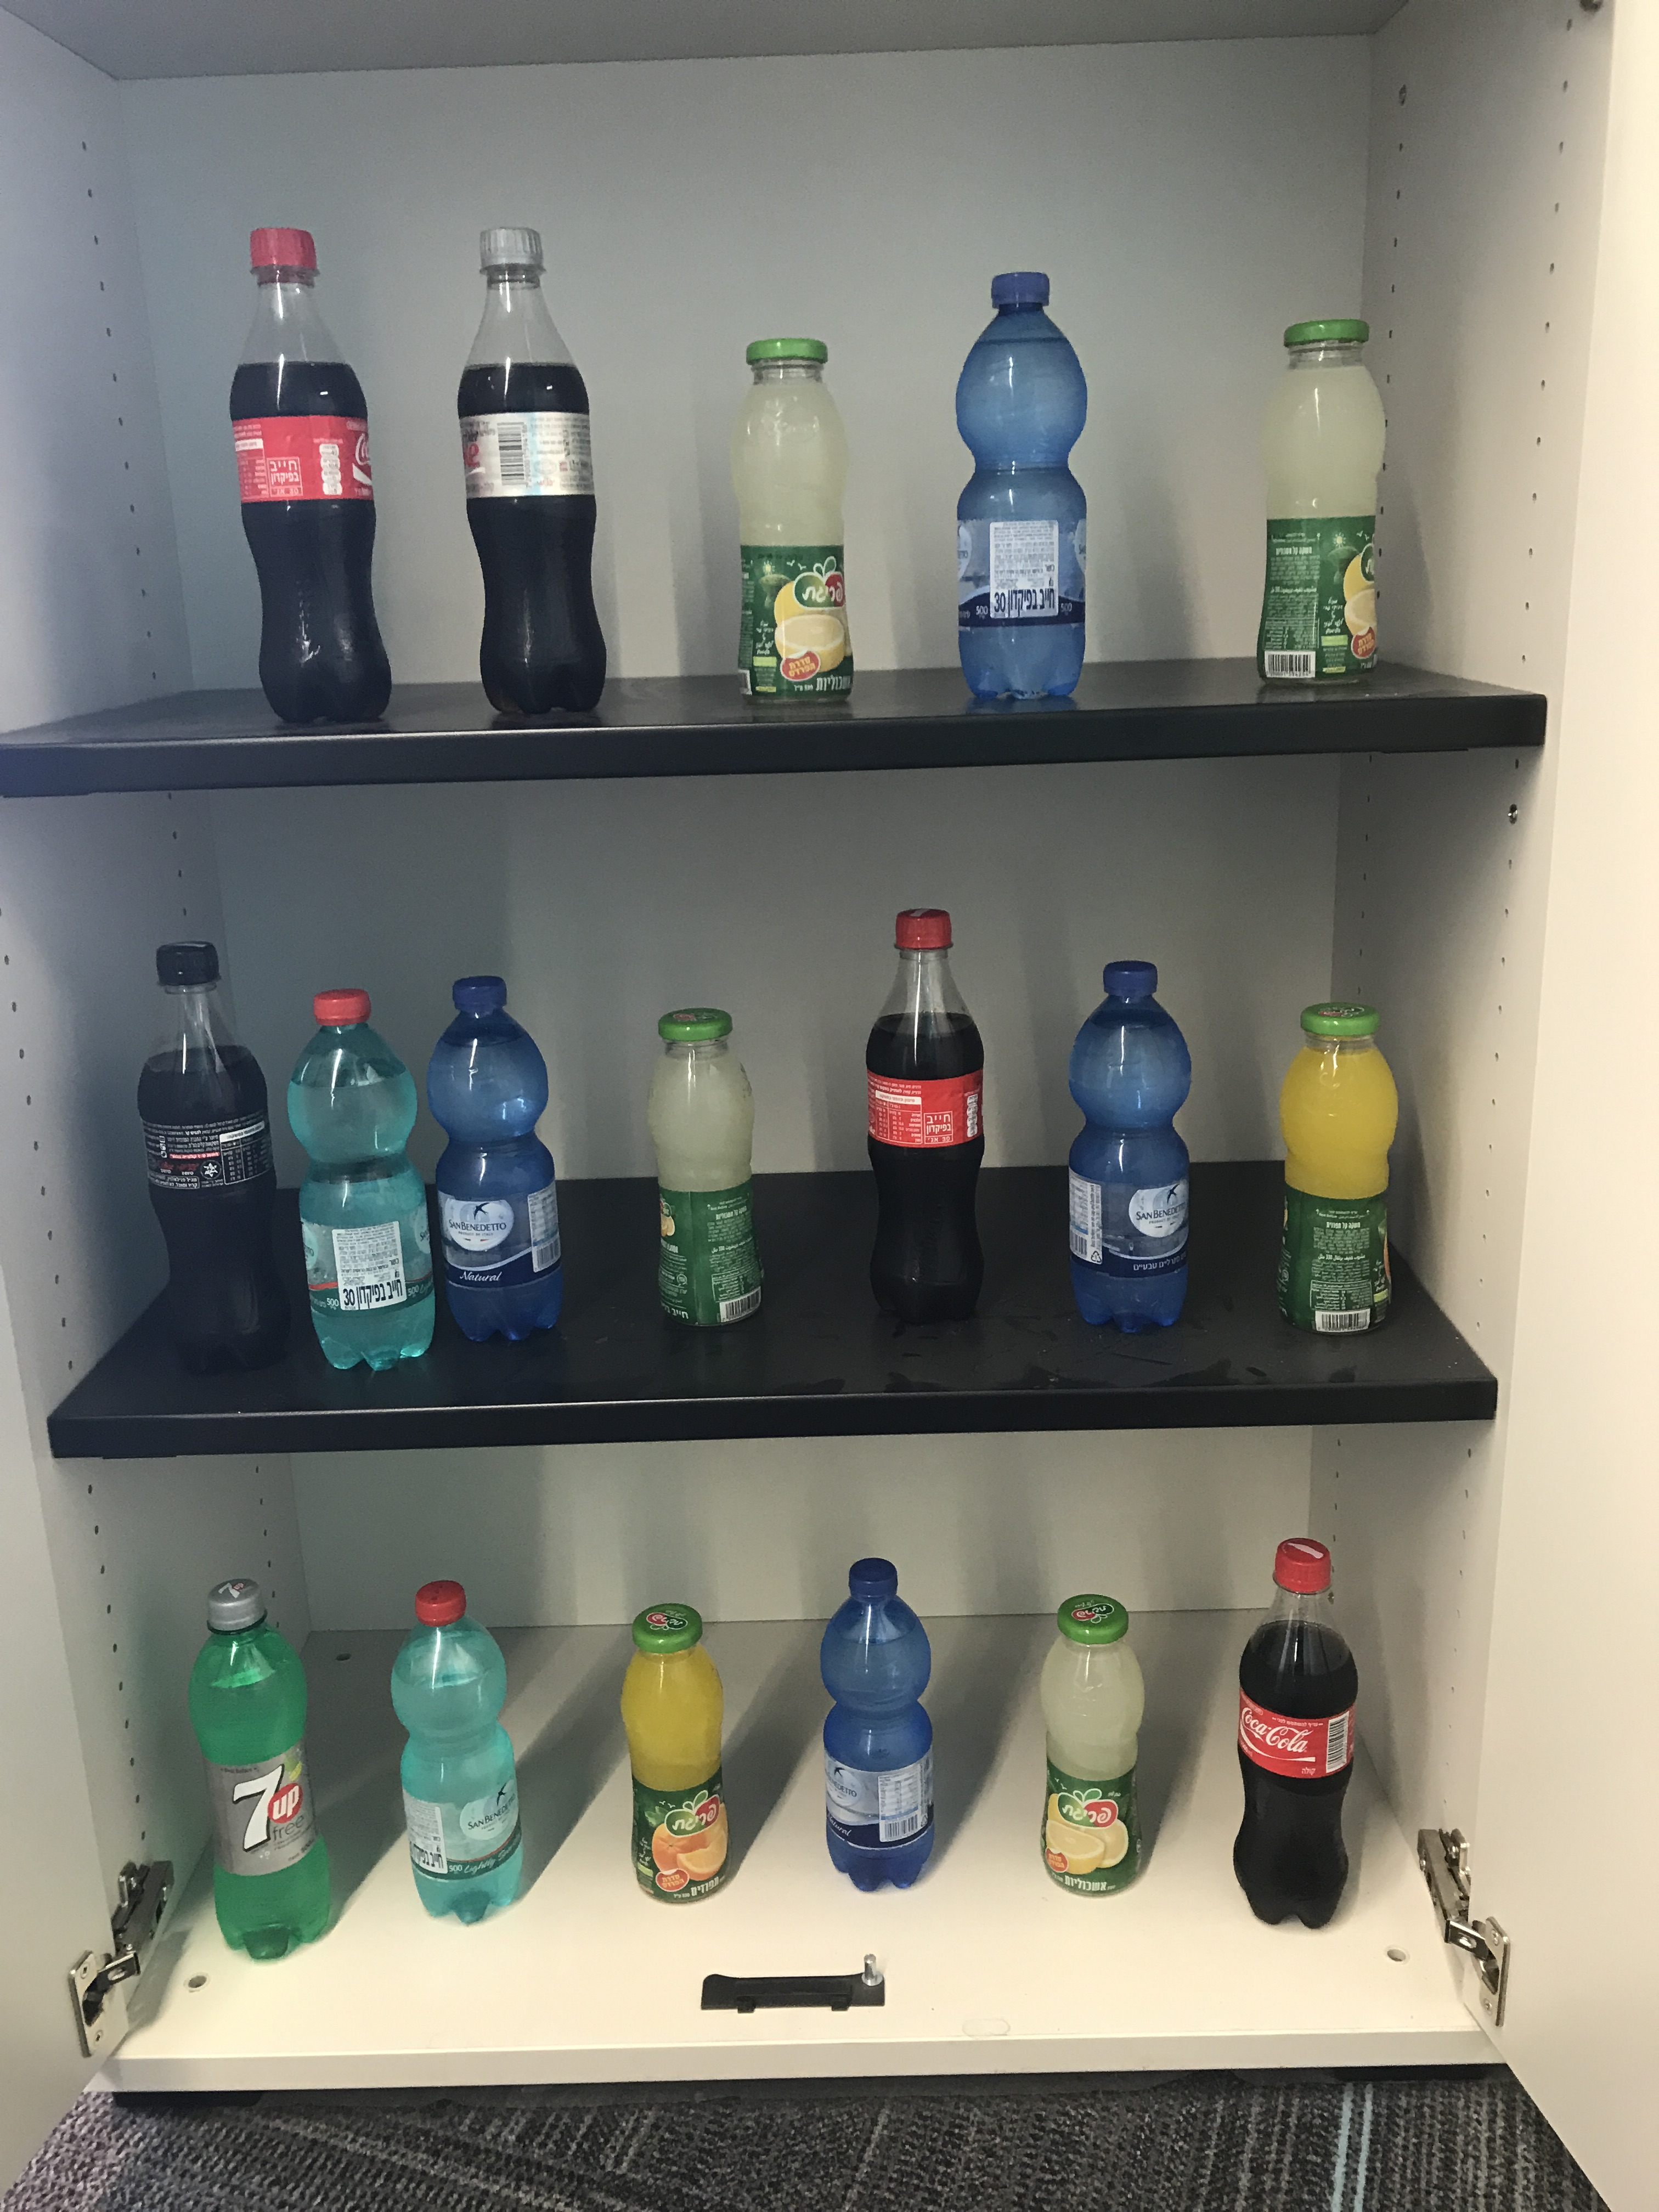

In [34]:
print("Invalid Example")
invalid_image = 'C:\local\cntk\Examples\Image\DataSets\Beverages\Recognition\Test\Invalid\IMG_4245.JPG'
D.display(D.Image(invalid_image, width=400, height=400))


# Load 

In [35]:
# from ObjectDetector import predict, get_configuration
def load_detector(model_path):
    model = load_model(model_path)
    FRCNN_DIM_W = model.arguments[0].shape[1]
    FRCNN_DIM_H = model.arguments[0].shape[2]
    labels_count = model.cls_pred.shape[1]
    model_classes = get_classes_description(model_path, labels_count)
    cfg = get_configuration(model_classes)
    evaluator = FasterRCNN_Evaluator(model, cfg)
    return evaluator, cfg, model_classes

# Detect Shelves

C:\local\cntk\Examples\Image\DataSets\Beverages\Recognition\Test\Invalid\IMG_4245.JPG


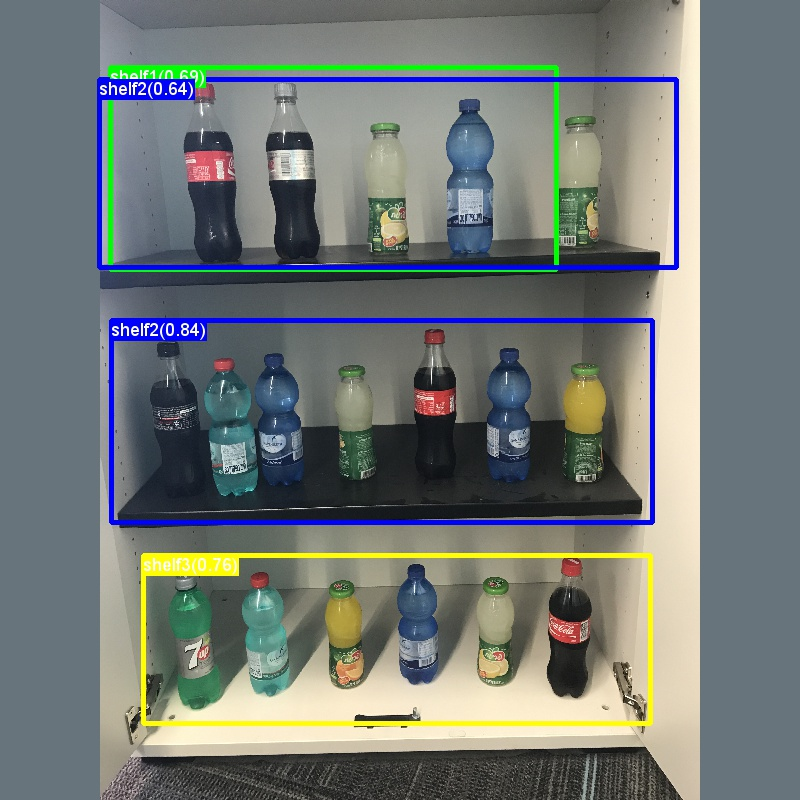

1 valid shelf1's detected 

[array([ 117.58,   71.93,  590.79,  286.52], dtype=float32)]


1 valid shelf3's detected 

[array([ 152.11,  590.23,  691.47,  768.68], dtype=float32)]


2 valid shelf2's detected 

[array([ 118.58,  341.03,  693.61,  555.08], dtype=float32), array([ 106.  ,   84.31,  719.22,  284.74], dtype=float32)]




In [36]:
shelves_model_path = r'C:\Vott_models\shelves\shelves.model'
evaluator, cfg, model_classes = load_detector(shelves_model_path)
bboxes, labels, scores = detect(invalid_image, evaluator, cfg)
D.display(D.Image(path.join(out_dir, path.basename(invalid_image)), width=800, height=800))

shelves = {"shelf1": [], "shelf2": [], "shelf3": []}

for i in range(len(bboxes)):
    if model_classes[labels[i]] != "__background__":
        shelves[model_classes[labels[i]]].append(bboxes[i])

for shelf in shelves:         
    print ("{} valid {}'s detected \n\n{}\n\n".format(len(shelves[shelf]), shelf, shelves[shelf]))

# Predict with Heuristic 1

Can you think of way we could use these boxes to tell that the policy is invalid?

Our heurisitc will work as follows 

- We are going to find the use the min y1 and max y2 of each of the tag classes
- We will confirm that soda is above juice which is above water
- For each of the max's we will ensure that there are no other clases that are in between them


In [37]:
def predict_shelves(img_path):
    bounds = {}
    bboxes, labels, scores = detect(img_path, evaluator, cfg)
    shelves = {"shelf1": [], "shelf2": [], "shelf3": []}
    for i in range(len(bboxes)):
        if model_classes[labels[i]] != "__background__":
            shelves[model_classes[labels[i]]].append(bboxes[i])
    #  We are going to find the use the min y1 and max y2 of each of the tag classes
    for shelf in shelves:
        if len(shelves[shelf]) == 0:
            return False
        y1 = min(shelves[shelf], key=lambda b: b[1])[1]
        y2 = max(shelves[shelf], key=lambda b: b[3])[3]
        bounds[shelf] = {"y1":y1, "y2":y2} 
    # We will confirm that shelf1 is above shelf2 which is above shelf3
    if (bounds["shelf1"]["y1"] < bounds["shelf2"]["y1"]) and (bounds["shelf2"]["y1"] < bounds["shelf3"]["y1"]):
        # For each of the max's we will ensure that there are no other clases that are in between them
        for b in bounds.keys():
            for shelf_num in (set(bounds.keys()) - set([b])):
                for s in shelves[shelf_num]:
                    if s[1] > bounds[b]["y1"] and s[3] < bounds[b]["y2"]:
                        return False 
        return True
    return False

In [38]:
print(predict_shelves(invalid_image))

C:\local\cntk\Examples\Image\DataSets\Beverages\Recognition\Test\Invalid\IMG_4245.JPG
False


C:\local\cntk\Examples\Image\DataSets\Beverages\Recognition\Train\Valid\IMG_4321.jpg
True


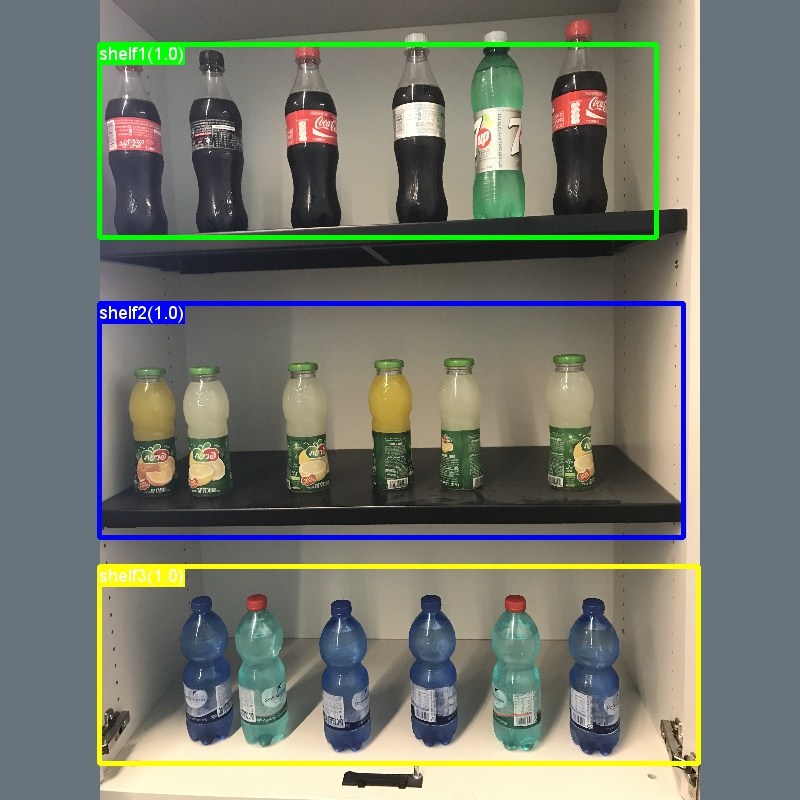

In [39]:
# true image 
valid_path = 'C:\local\cntk\Examples\Image\DataSets\Beverages\Recognition\Train\Valid\IMG_4321.jpg'
# D.display(D.Image(valid_path, width=800, height=800))

print(predict_shelves(valid_path))
D.display(D.Image(path.join(out_dir, path.basename(valid_path)), width=400, height=400))


# Benchmark Shelf Heuristic

In [40]:
tokens = []
with open(testing_map, 'r') as input_file:
    tokens = [line.rstrip().split('\t') for line in input_file]    
y_true, y_pred = zip(*[(int(t[1]), int(predict_shelves(t[0]))) for t in tokens])

C:\local\cntk\Examples\Image\DataSets\Beverages\Recognition\Test\Invalid\IMG_4196.JPG
C:\local\cntk\Examples\Image\DataSets\Beverages\Recognition\Test\Invalid\IMG_4201.JPG
C:\local\cntk\Examples\Image\DataSets\Beverages\Recognition\Test\Invalid\IMG_4202.JPG
C:\local\cntk\Examples\Image\DataSets\Beverages\Recognition\Test\Invalid\IMG_4204.JPG
C:\local\cntk\Examples\Image\DataSets\Beverages\Recognition\Test\Invalid\IMG_4208.JPG
C:\local\cntk\Examples\Image\DataSets\Beverages\Recognition\Test\Invalid\IMG_4211.JPG
C:\local\cntk\Examples\Image\DataSets\Beverages\Recognition\Test\Invalid\IMG_4217.JPG
C:\local\cntk\Examples\Image\DataSets\Beverages\Recognition\Test\Invalid\IMG_4219.JPG
C:\local\cntk\Examples\Image\DataSets\Beverages\Recognition\Test\Invalid\IMG_4221.JPG
C:\local\cntk\Examples\Image\DataSets\Beverages\Recognition\Test\Invalid\IMG_4225.JPG
C:\local\cntk\Examples\Image\DataSets\Beverages\Recognition\Test\Invalid\IMG_4228.JPG
C:\local\cntk\Examples\Image\DataSets\Beverages\Recogn

             precision    recall  f1-score   support

          0       1.00      0.83      0.91        30
          1       0.86      1.00      0.92        30

avg / total       0.93      0.92      0.92        60

Confusion matrix, without normalization
[[25  5]
 [ 0 30]]
Normalized confusion matrix
[[ 0.83  0.17]
 [ 0.    1.  ]]


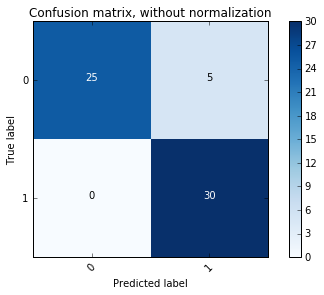

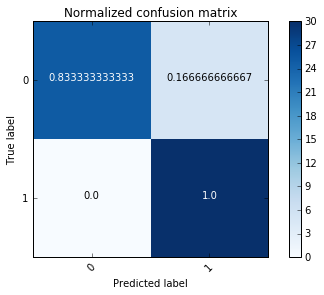

In [41]:
start_time = time.time()

print(metrics.classification_report(y_true, y_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
class_names = sorted(set(y_true))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

# Detect Bottles

C:\local\cntk\Examples\Image\DataSets\Beverages\Recognition\Test\Invalid\IMG_4245.JPG


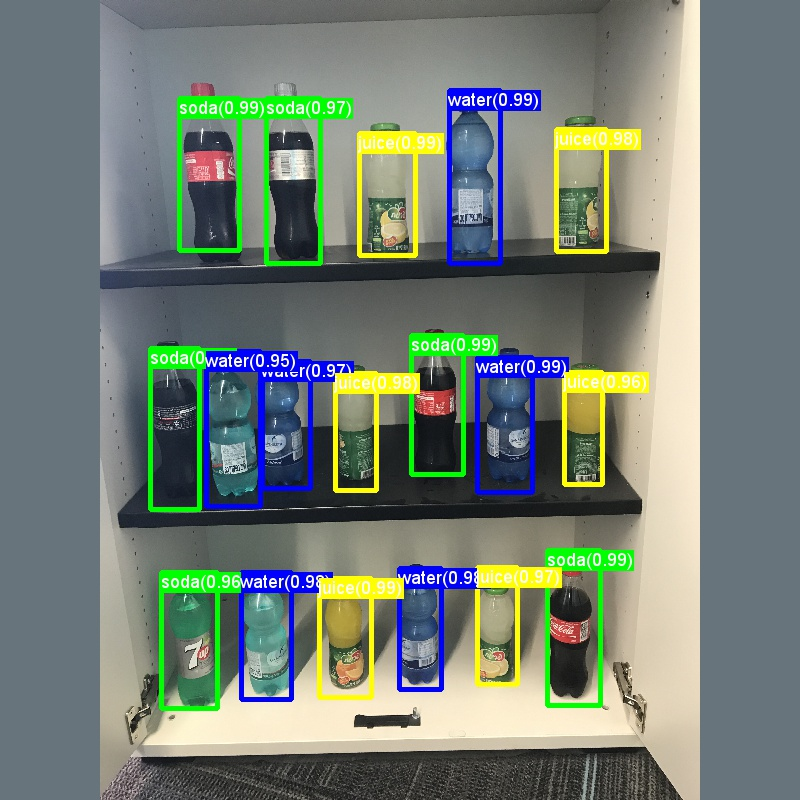

6 water's detected 

[array([ 507.85,  379.4 ,  565.64,  522.93], dtype=float32), array([ 477.74,   96.13,  531.97,  279.68], dtype=float32), array([ 256.19,  608.55,  310.24,  743.47], dtype=float32), array([ 424.23,  604.5 ,  469.14,  732.34], dtype=float32), array([ 278.39,  383.57,  330.4 ,  518.9 ], dtype=float32), array([ 219.34,  373.8 ,  276.36,  538.39], dtype=float32)]


6 soda's detected 

[array([ 437.3 ,  356.26,  492.51,  504.36], dtype=float32), array([ 581.22,  584.51,  637.98,  749.31], dtype=float32), array([ 190.39,  104.82,  254.85,  265.91], dtype=float32), array([ 282.98,  105.02,  340.03,  279.61], dtype=float32), array([ 171.53,  608.67,  231.08,  752.63], dtype=float32), array([ 159.39,  370.37,  211.58,  540.83], dtype=float32)]


6 juice's detected 

[array([ 381.96,  141.9 ,  441.57,  271.97], dtype=float32), array([ 339.47,  614.51,  394.99,  741.32], dtype=float32), array([ 591.7 ,  137.18,  644.65,  266.87], dtype=float32), array([ 356.17,  396.59,  400.0

In [42]:
beverage_model_path =  r'C:\Vott_models\soda\beverages.model'
evaluator, cfg, model_classes = load_detector(beverage_model_path)
bboxes, labels, scores = detect(invalid_image, evaluator, cfg)
D.display(D.Image(path.join(out_dir, path.basename(invalid_image)), width=800, height=800))

beverages = {"soda": [], "water": [], "juice": []}

for i in range(len(bboxes)):
    if model_classes[labels[i]] != "__background__":
        beverages[model_classes[labels[i]]].append(bboxes[i])

for bev in beverages:         
    print ("{} {}'s detected \n\n{}\n\n".format(len(beverages[bev]), bev, beverages[bev]))

# Predict with Heuristic 2

Can you think of way we could use these boxes to tell that the policy is invalid?

Our heurisitc will work as follows 

- We are going to find the use the min y1 and max y2 of each of the tag classes
- We will confirm that soda is above juice which is above water
- For each of the max's we will ensure that there are no other clases that are in between them


In [43]:
def predict_bottles(img_path):
    bounds = {}
    bboxes, labels, scores = detect(img_path, evaluator, cfg)
    beverages = {"soda": [], "water": [], "juice": []}
    for i in range(len(bboxes)):
        if model_classes[labels[i]] != "__background__":
            beverages[model_classes[labels[i]]].append(bboxes[i])
    #  We are going to find the use the min y1 and max y2 of each of the tag classes
    for bev in beverages:
        if len(beverages[bev]) == 0:
            return False
        y1 = min(beverages[bev], key=lambda b: b[1])[1]
        y2 = max(beverages[bev], key=lambda b: b[3])[3]
        bounds[bev] = {"y1":y1, "y2":y2} 
    # We will confirm that soda is above juice which is above water
    if (bounds["soda"]["y1"] < bounds["juice"]["y1"]) and (bounds["juice"]["y1"] < bounds["water"]["y1"]):
        # For each of the max's we will ensure that there are no other clases that are in between them
        for b in bounds.keys():
            for bev_type in (set(bounds.keys()) - set([b])):
                for bev in beverages[bev_type]:
                    if bev[1] > bounds[b]["y1"] and bev[3] < bounds[b]["y2"]:
                        return False 
        return True
    else:
        return False


In [44]:
print(predict_bottles(invalid_image))

C:\local\cntk\Examples\Image\DataSets\Beverages\Recognition\Test\Invalid\IMG_4245.JPG
False


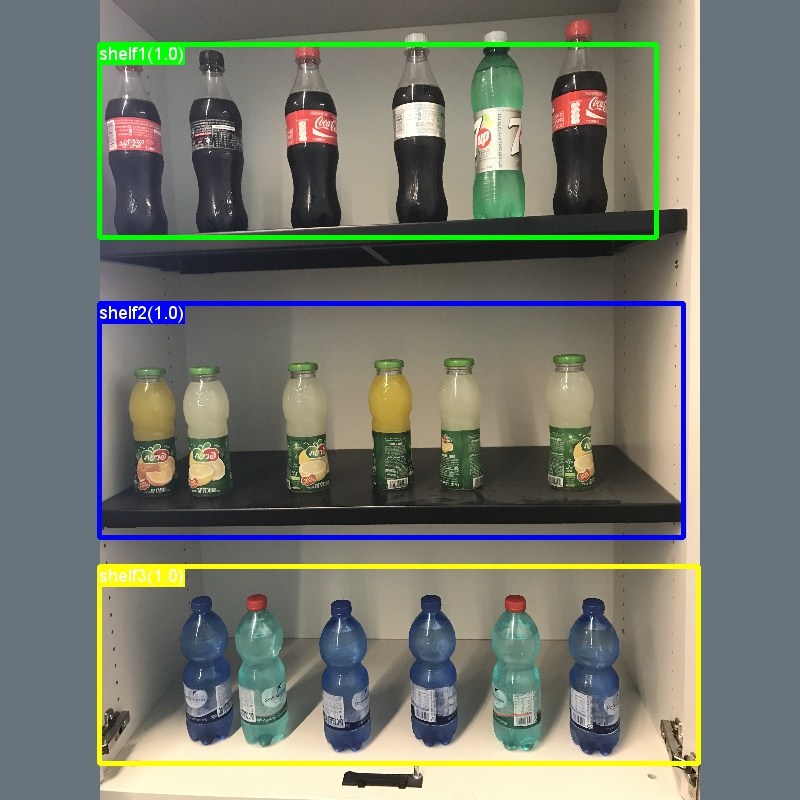

C:\local\cntk\Examples\Image\DataSets\Beverages\Recognition\Train\Valid\IMG_4321.jpg
True


In [45]:
# true image 
valid_path = 'C:\local\cntk\Examples\Image\DataSets\Beverages\Recognition\Train\Valid\IMG_4321.jpg'
D.display(D.Image(path.join(out_dir, path.basename(valid_path)), width=800, height=800))

print(predict_bottles(valid_path))

# Benchmark Bottle Heuristic

In [46]:
tokens = []
with open(testing_map, 'r') as input_file:
    tokens = [line.rstrip().split('\t') for line in input_file]    
y_true, y_pred = zip(*[(int(t[1]), int(predict_bottles(t[0]))) for t in tokens])


C:\local\cntk\Examples\Image\DataSets\Beverages\Recognition\Test\Invalid\IMG_4196.JPG
C:\local\cntk\Examples\Image\DataSets\Beverages\Recognition\Test\Invalid\IMG_4201.JPG
C:\local\cntk\Examples\Image\DataSets\Beverages\Recognition\Test\Invalid\IMG_4202.JPG
C:\local\cntk\Examples\Image\DataSets\Beverages\Recognition\Test\Invalid\IMG_4204.JPG
C:\local\cntk\Examples\Image\DataSets\Beverages\Recognition\Test\Invalid\IMG_4208.JPG
C:\local\cntk\Examples\Image\DataSets\Beverages\Recognition\Test\Invalid\IMG_4211.JPG
C:\local\cntk\Examples\Image\DataSets\Beverages\Recognition\Test\Invalid\IMG_4217.JPG
C:\local\cntk\Examples\Image\DataSets\Beverages\Recognition\Test\Invalid\IMG_4219.JPG
C:\local\cntk\Examples\Image\DataSets\Beverages\Recognition\Test\Invalid\IMG_4221.JPG
C:\local\cntk\Examples\Image\DataSets\Beverages\Recognition\Test\Invalid\IMG_4225.JPG
C:\local\cntk\Examples\Image\DataSets\Beverages\Recognition\Test\Invalid\IMG_4228.JPG
C:\local\cntk\Examples\Image\DataSets\Beverages\Recogn

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        30
          1       1.00      1.00      1.00        30

avg / total       1.00      1.00      1.00        60

Confusion matrix, without normalization
[[30  0]
 [ 0 30]]
Normalized confusion matrix
[[ 1.  0.]
 [ 0.  1.]]


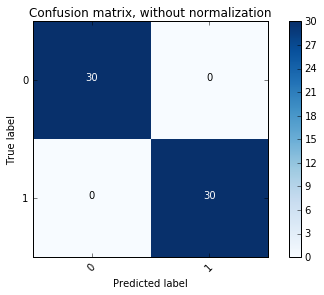

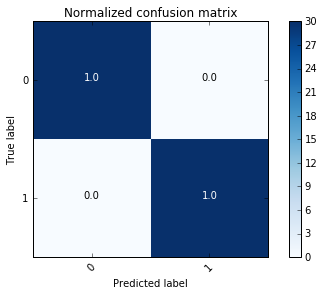

In [47]:
start_time = time.time()

print(metrics.classification_report(y_true, y_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
class_names = sorted(set(y_true))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()